<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI/blob/master/6_1_C_RNN_decoding_models_of_EEG_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Something you have to do everytime you use colab and the data are in your google drive

In [0]:
!pip install -U mne

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Requirement already up-to-date: mne in /usr/local/lib/python3.6/dist-packages (0.18.1)


In [0]:
epochs_id = 'https://drive.google.com/open?id=1ZMj4taxY6Y5e-qtfgl-wo5956N1g_vio'.split('id=')[-1]
downloaded = drive.CreateFile({'id':epochs_id})
downloaded.GetContentFile(f'epochs-epo.fif')

# let's look at the data first

In [0]:
import mne
import pandas as pd
import numpy as np

In [0]:
epochs = mne.read_epochs('epochs-epo.fif',preload = True)

Reading epochs-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -200.00 ...    1250.00 ms
        0 CTF compensation matrices available
1441 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated


## get the unique events and its event ids

In [0]:
epochs.event_id

{'living conscious': 28,
 'living glimpse': 27,
 'living unconscious': 26,
 'nonliving conscious': 38,
 'nonliving glimpse': 37,
 'nonliving unconscious': 36}

## get the onset time of the event and its event ids

In [0]:
epochs.events

array([[  22806,       0,      28],
       [  27646,       0,      26],
       [  34050,       0,      38],
       ...,
       [8038704,       0,      28],
       [8042983,       0,      26],
       [8046801,       0,      37]])

In [0]:
conscious   = mne.concatenate_epochs([epochs[name] for name in epochs.event_id.keys() if (' conscious' in name)])
glimpse     = mne.concatenate_epochs([epochs[name] for name in epochs.event_id.keys() if ('glimpse' in name)])
unconscious = mne.concatenate_epochs([epochs[name] for name in epochs.event_id.keys() if ('unconscious' in name)])
del epochs

341 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
553 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
547 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped


### right click on the grey bar of the code cell and you can view the outputs in full screen

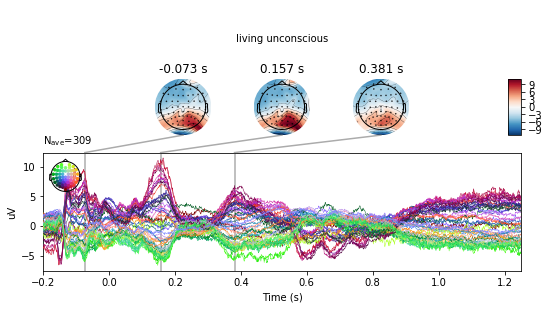

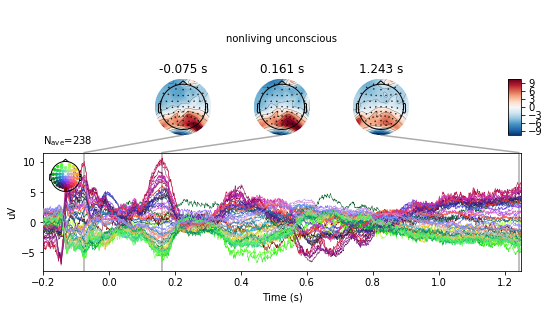

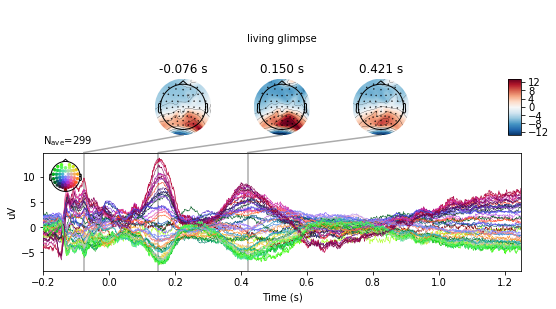

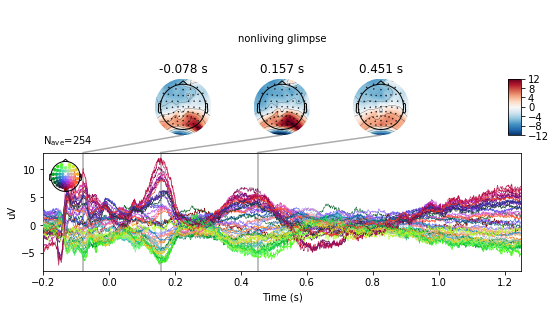

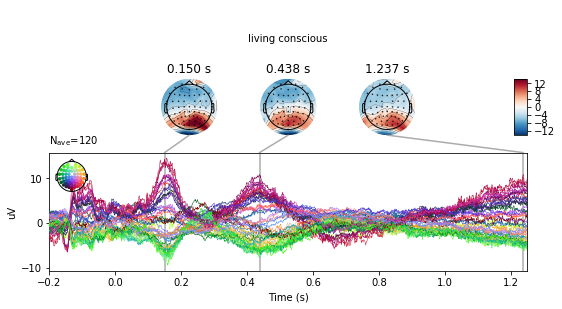

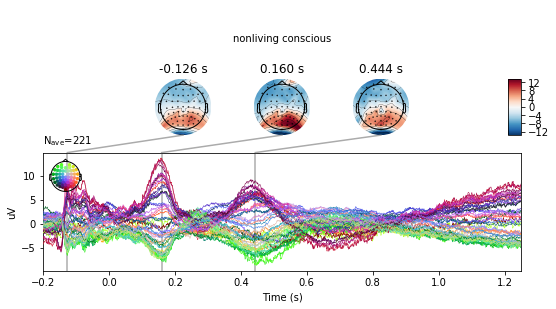

In [0]:
for ii,(epochs,conscious_state) in enumerate(zip([unconscious.copy(),
                                                      glimpse.copy(),
                                                      conscious.copy()],
                                                     ['unconscious',
                                                      'glimpse',
                                                      'conscious'])):
    for unique_id in list(epochs.event_id.keys()):
        epochs[unique_id].average().plot_joint(title = unique_id)
    

## set up a baseline model - logistic regression

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.utils import shuffle
from mne.decoding import Scaler,Vectorizer

n_splits = 10
n_jobs = -1
logistic = LogisticRegression(
                              solver        = 'lbfgs',
                              max_iter      = int(1e3),
                              random_state  = 12345,
                              class_weight  = 'balanced'
                              )

In [0]:
for ii,(epochs,conscious_state) in enumerate(zip([unconscious.copy(),
                                                      glimpse.copy(),
                                                      conscious.copy()],
                                                     ['unconscious',
                                                      'glimpse',
                                                      'conscious'])):
    epochs.resample(100) # to speed things up
    
    cv          = StratifiedShuffleSplit(
                             n_splits       = n_splits, 
                             test_size      = 0.1, 
                             random_state   = 12345)
    pipeline    = make_pipeline(
                             Scaler(epochs.info),
                             Vectorizer(),
                             StandardScaler(),
                             clone(logistic),
                             )
    X,y = epochs.get_data(),epochs.events[:,-1]
    y = y //10 -2
    np.random.seed(12345)
    X,y = shuffle(X,y)
    
    scores      = cross_val_score(
                             pipeline,
                             X,
                             y,
                             scoring         = 'roc_auc',
                             cv              = cv,
                             n_jobs          = n_jobs,
                             )
    plscores = scores.copy()
    print(f'decode {conscious_state} (N = {X.shape[0]}) = {plscores.mean():.4f}+/-{plscores.std():.4f}')

decode unconscious (N = 547) = 0.4762+/-0.0566
decode glimpse (N = 553) = 0.5906+/-0.0508
decode conscious (N = 341) = 0.4707+/-0.0818


## RNN classifier (n_parameters = 216,487)

### Architecture:

Since the data is (n_samples x n_channels x n_time_steps), we can pass the time steps to a RNN layer that contains the same number of RNN neurons as the time step, so that each neuron would take the input of the time step and the previous neuron. And then pass the output of this RNN to another RNN, and then classify the targets based on the last RNN outputs. 

### RNN layer - Gated Recurrent Unit -- GRU

This is chosen because its simplicity compared to LSTM. 

**LSTM**

![LSTM](https://cdn-images-1.medium.com/max/800/1*goJVQs-p9kgLODFNyhl9zA.gif)

**GRU**

![GRU](https://cdn-images-1.medium.com/max/800/1*FpRS0C3EHQnELVaWRvb8bg.gif)

source: [Animated RNN, LSTM and GRU](https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45)

### helper funtion

In [0]:
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    from keras.callbacks import ModelCheckpoint,EarlyStopping
    """
    Make call back function lists for the keras models
    
    Inputs
    -------------------------
    model_name: directory of where we want to save the model and its name
    monitor: the criterion we used for saving or stopping the model
    mode: min --> lower the better, max --> higher the better
    verboser: printout the monitoring messages
    min_delta: minimum change for early stopping
    patience: temporal windows of the minimum change monitoring
    frequency: temporal window steps of the minimum change monitoring
    
    Return
    --------------------------
    CheckPoint: saving the best model
    EarlyStopping: early stoppi....
    """
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          = monitor,# saving criterion
                                 save_best_only   = True,# save only the best model
                                 mode             = mode,# saving criterion
                                 period           = frequency,# frequency of check the update 
                                 verbose          = verbose# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          = monitor,
                                 min_delta        = min_delta,
                                 patience         = patience,
                                 verbose          = verbose, 
                                 mode             = mode,
                                 )
    return [checkPoint,earlyStop]
def preprocess_features(X,vectorizer = None,scaler = None):
    from sklearn.preprocessing import MinMaxScaler
    if vectorizer is None:
        vectorizer          = mne.decoding.Vectorizer()
        X_vec               = vectorizer.fit_transform(X)
    else:
        X_vec               = vectorizer.transform(X)
    if scaler is None:
        scaler              = MinMaxScaler()
        X_vec_standard      = scaler.fit_transform(X_vec)
    else:
        X_vec_standard      = scaler.transform(X_vec)
    X_vec_tran          = vectorizer.inverse_transform(X_vec_standard)
    
    return X_vec_tran,vectorizer,scaler

In [0]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras import layers,Model, optimizers,losses,regularizers#,Sequential
from keras import metrics as k_metrics
import keras.backend as K

In [0]:
n_splits = 5
n_epochs = int(2e2)
results = []
for ii,(epochs,conscious_state) in enumerate(zip([unconscious.copy(),
                                                      glimpse.copy(),
                                                      conscious.copy()],
                                                     ['unconscious',
                                                      'glimpse',
                                                      'conscious'])):
    epochs.resample(100) # to speed things up
    
    K.clear_session() # save GPU memory
    X,y                 = epochs.get_data(),epochs.events[:,-1]
    y                   = y //10 -2

    y_                  = pd.get_dummies(y) # make one-hot targets

    X,targets           = X,y_.values
    # scale up the EEG data values to reasonable range (1e-6 to 1)
    X                   = mne.decoding.Scaler(epochs.info).fit_transform(X)
    # swap the axes between the channels and time step
    X                   = np.swapaxes(X,1,2)
    
    ss                  = [] # preallocate the result storage
    cv          = StratifiedShuffleSplit(
                             n_splits       = n_splits, 
                             test_size      = 0.1, 
                             random_state   = 12345)
    for fold,(idx_,idx_test) in enumerate(cv.split(X,y)):
        print(f'fold {fold + 1}')
        # further split the training data into train and validation
        X_train,X_valid,y_train,y_valid = train_test_split(
                X[idx_],targets[idx_],
                test_size               = 0.05,
                random_state            = 12345,
                shuffle                 = True,)
        # scale the data to between 0 and 1
        X_train,vectorizer,scaler = preprocess_features(X_train)
        # feature processing should not be fit on validation or test data
        X_valid,_,_ = preprocess_features(X_valid,vectorizer,scaler)
        
        
        # some hyperparameters that don't change much for any type of DNNs
        model_name  = 'temp.hdf5'
        batch_size  = 16
        timesteps   = X.shape[1]
        data_dim    = X.shape[2]

        # the dynamic way of making a neural network
        inputs      = layers.Input(
                           shape                    = X.shape[1:],
                           batch_shape              = (None,timesteps,data_dim),
                           name                     = 'inputs'
                           )
        rnn         = layers.GRU(  return_state = True,return_sequences = True, # don't need stateful - batch dependent
                           units                    = timesteps,
                           kernel_regularizer       = regularizers.l2(),
                           activity_regularizer     = regularizers.l1(),
                           recurrent_regularizer    = regularizers.l2(),
                           dropout                  = 0.5,
                           recurrent_dropout        = 0.2,
                           )(inputs)
        rnn         = layers.GRU(
                           units                    = timesteps,
                           #kernel_regularizer       = regularizers.l2(),
                           #activity_regularizer     = regularizers.l1(),
                           #recurrent_regularizer    = regularizers.l2(),
                           dropout                  = 0.5,
                           recurrent_dropout        = 0.2,
                           )(rnn[0],initial_state = rnn[1]) # we use the internal state (memory control unit) to initialize the next RNN layer
        # heavily regularize the prediction
        outputs     = layers.Dense(
                        targets.shape[1],
                        activation                  = 'softmax',
                        #kernel_regularizer          = regularizers.l2(),
                        activity_regularizer        = regularizers.l1(1),
                        name                        = 'outputs'
                        )(rnn)
        classifier = Model(inputs,outputs,name = 'clf')
        # classifier.summary()

        print('training ... ')
        classifier.compile(optimizer                = optimizers.adam(),
                           loss                     = losses.categorical_crossentropy,
                           metrics                  = [k_metrics.categorical_accuracy])

        def call_back_dict(care = 'loss'): # helper function for early stopping
            if care == 'loss':
                return dict(
                        monitor = 'val_{}'.format(classifier.metrics_names[0]),
                        mode = 'min',
                        patience = 2,
                        min_delta = 1e-2)
            elif care == 'metric':
                return dict(
                        monitor = 'val_{}'.format(classifier.metrics_names[-1]),
                        mode = 'max',
                        patience = 10,
                        min_delta = 1e-4)
            else:
                print('why?')
        callBackList = make_CallBackList(
               model_name,
               verbose          = 0,# print out the process
               frequency        = 1,
               **call_back_dict('loss')
               )
        # before we train the model, we shuffle the order of both the features and targets
        from sklearn.utils import shuffle
        np.random.seed(12345)
        X_train,y_train = shuffle(X_train,y_train)

        classifier.fit(X_train,y_train,
                       batch_size               = batch_size,
                       epochs                   = n_epochs,
                       validation_data          = (X_valid,y_valid),
                       callbacks                = callBackList,
                       verbose                  = 0)
        classifier.load_weights(model_name)
    
        X_test,_,_ = preprocess_features(X[idx_test],vectorizer,scaler)
        print(f'{conscious_state},fold {fold+1}',
              classifier.evaluate(X_test,
                                  targets[idx_test],
                                  batch_size = batch_size,
                                  verbose = 0,))
        preds = classifier.predict(X_test,verbose = 0)
        ss.append(metrics.roc_auc_score(targets[idx_test],
                                        preds))
    results.append([conscious_state,ss])
    print(f'{conscious_state:10} {np.mean(ss):.4f} +/- {np.std(ss):.4f}\n')

fold 1
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_1/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


unconscious,fold 1 [19.014577917619185, 0.563636364178224]
fold 2
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_3/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


unconscious,fold 2 [18.88810821879994, 0.563636364178224]
fold 3
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_5/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


unconscious,fold 3 [18.857923368974166, 0.563636364178224]
fold 4
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_7/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


unconscious,fold 4 [18.861323460665616, 0.563636366887526]
fold 5
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_10 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_9/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


unconscious,fold 5 [18.98525446111506, 0.563636366887526]
unconscious 0.5094 +/- 0.0600

fold 1
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_1/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


glimpse,fold 1 [19.036685943603516, 0.5357142857142857]
fold 2
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_3/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


glimpse,fold 2 [19.059915951320104, 0.5357142857142857]
fold 3
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_5/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


glimpse,fold 3 [17.977036339896067, 0.5357142857142857]
fold 4
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_7/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


glimpse,fold 4 [19.161594799586705, 0.5357142857142857]
fold 5
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_10 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_9/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


glimpse,fold 5 [19.04100513458252, 0.5357142857142857]
glimpse    0.4644 +/- 0.0609

fold 1
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_1/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


conscious,fold 1 [19.19886680330549, 0.6571428571428571]
fold 2
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_3/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


conscious,fold 2 [18.852835219247, 0.657142858845847]
fold 3
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_5/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


conscious,fold 3 [18.884135804857525, 0.657142858845847]
fold 4
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_7/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


conscious,fold 4 [19.31235008239746, 0.657142858845847]
fold 5
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_10 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_9/while/Exit_3:0' shape=(?, 145) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


conscious,fold 5 [18.857731328691756, 0.657142857994352]
conscious  0.4447 +/- 0.0707



## CNN-RNN  classifier (n_parameters = 690,454)



### Architecture:

Since the data is (n_samples x n_channels x n_time_steps), we can perform a convolution on the time steps and then pass the convoled "features" to a RNN layer, which could speed up RNN processing, even though we have way more parameters. In this case, we will need more regularization to avoid overfitting. 


Nowadays, 1D convolutional layers are widely used in dimension reduction for time series data: 

![1dconv](https://www.researchgate.net/publication/324177888/figure/fig3/AS:611641670504448@1522838146178/Calculations-involved-in-a-1D-convolution-operation.png)

Due to its simplicity in both computation and architecture, I decide to use 1D convolution to perform some sort of "feature processing" before feed the outputs to a RNN. 

The reasonal behind this is that convolution would identify temporal patterns locally and push them globally to the next layer. After a few convolutional processing, both the local and global temporal patterns are "smoothed" for better signal-to-noise ratio for RNN. 

### helper function

In [0]:
def cnn_block(x,filters = 128 , step = 10,idx_ = 0):
    cnn       = layers.Conv1D(
                                 filters                = filters,
                                 kernel_size            = int(timesteps / step),
                                 padding                = 'valid',
                                 data_format            = 'channels_last',
                                 activation             = 'selu',
                                 kernel_regularizer     = regularizers.l2(1e-2),
#                                 activity_regularizer   = regularizers.l1(),
                                 name                   = f'cnn_{idx_}')(x)
    cnn         = layers.AveragePooling1D(data_format = 'channels_last',name = f'pool_{idx_}')(cnn)
    cnn         = layers.Dropout(0.5,name = f'drop_{idx_}')(cnn)
    return cnn

In [0]:
n_splits = 5
n_epochs = int(2e2)
results = []
for ii,(epochs,conscious_state) in enumerate(zip([unconscious.copy(),
                                                      glimpse.copy(),
                                                      conscious.copy()],
                                                     ['unconscious',
                                                      'glimpse',
                                                      'conscious'])):
    epochs.resample(100)
    
    K.clear_session() # save GPU memory
    X,y                 = epochs.get_data(),epochs.events[:,-1]
    y                   = y //10 -2

    y_                  = pd.get_dummies(y) # make one-hot targets

    X,targets           = X,y_.values
    # scale up the EEG data values to reasonable range (1e-6 to 1)
    X                   = mne.decoding.Scaler(epochs.info).fit_transform(X)
    # swap the axes between the channels and time step
    X                   = np.swapaxes(X,1,2)
    
    ss                  = []
    cv          = StratifiedShuffleSplit(
                             n_splits       = n_splits, 
                             test_size      = 0.1, 
                             random_state   = 12345)
    for fold,(idx_,idx_test) in enumerate(cv.split(X,y)):
        print(f'fold {fold + 1}')
        X_train,X_valid,y_train,y_valid = train_test_split(
                X[idx_],targets[idx_],
                test_size               = 0.05,
                random_state            = 12345,
                shuffle                 = True,)
        
        # scale the data to between 0 and 1
        X_train,vectorizer,scaler = preprocess_features(X_train)
        # feature processing should not be fit on validation or test data
        X_valid,_,_ = preprocess_features(X_valid,vectorizer,scaler)
        
        
            
        model_name  = 'CRNN.hdf5'
        batch_size  = 8
        timesteps   = X.shape[1]
        data_dim    = X.shape[2]

        inputs      = layers.Input(
                           shape                    = X.shape[1:],
                           batch_shape              = (None,timesteps,data_dim),
                           name                     = 'inputs'
                           )

        cnn         = cnn_block(inputs, filters = 256,idx_=1)
        cnn         = cnn_block(cnn,    filters = 128,idx_=2)
        #cnn         = cnn_block(cnn,    filters = 64,idx_=3)
        
        rnn,states        = layers.GRU(
                           units = cnn.shape.as_list()[1],
                           return_state=True, return_sequences=True,
                           #kernel_regularizer       = regularizers.l2(),
                           #activity_regularizer     = regularizers.l1(),
                           #recurrent_regularizer    = regularizers.l2(),
                           dropout                  = 0.5,
                           recurrent_dropout        = 0.2,
                           )(cnn)
        rnn         = layers.GRU(
                           units = cnn.shape.as_list()[1],
                           return_sequences=False,return_state=False,
                           #kernel_regularizer       = regularizers.l2(),
                           #activity_regularizer     = regularizers.l1(),
                           #recurrent_regularizer    = regularizers.l2(),
                           dropout                  = 0.5,
                           recurrent_dropout        = 0.2,
                           )(rnn,initial_state = states)
        outputs     = layers.Dense(
                        targets.shape[1],
                        activation                  = 'softmax',
                        #kernel_regularizer          = regularizers.l2(),
                        activity_regularizer        = regularizers.l1(1),
                        name                        = 'outputs'
                        )(rnn)
        classifier = Model(inputs,outputs,name = 'clf')
        # classifier.summary()

        print('training ... ')
        classifier.compile(optimizer                = optimizers.adam(),
                           loss                     = losses.categorical_crossentropy,
                           metrics                  = [k_metrics.binary_accuracy])

        def call_back_dict(care = 'loss'):
            if care == 'loss':
                return dict(
                        monitor = 'val_{}'.format(classifier.metrics_names[0]),
                        mode = 'min',
                        patience = 2,
                        min_delta = 1e-2)
            elif care == 'metric':
                return dict(
                        monitor = 'val_{}'.format(classifier.metrics_names[-1]),
                        mode = 'max',
                        patience = 10,
                        min_delta = 1e-4)
            else:
                print('why?')
        callBackList = make_CallBackList(
               model_name,
               verbose          = 0,# print out the process
               frequency        = 1,
               **call_back_dict('loss')
               )

        from sklearn.utils import shuffle
        np.random.seed(12345)
        X_train,y_train = shuffle(X_train,y_train)

        classifier.fit(X_train,y_train,
                       batch_size               = batch_size,
                       epochs                   = n_epochs,
                       validation_data          = (X_valid,y_valid),
                       callbacks                = callBackList,
                       verbose                  = 0)
        classifier.load_weights(model_name)

        X_test,_,_ = preprocess_features(X[idx_test],vectorizer,scaler)
        print(f'{conscious_state},fold {fold+1}',
              classifier.evaluate(X_test,
                                  targets[idx_test],
                                  batch_size = batch_size,
                                  verbose = 0,))
        preds = classifier.predict(X_test,verbose = 0)
        ss.append(metrics.roc_auc_score(targets[idx_test],
                                        preds))
    results.append([conscious_state,ss])
    print(f'{conscious_state:10} {np.mean(ss):.4f} +/- {np.std(ss):.4f}\n')
#[f'{item[0]:10} {np.mean(item[1]):.4f} +/- {np.std(item[1]):.4f}\n') for item in results]

fold 1
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_1/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


unconscious,fold 1 [8.710217666625976, 0.563636364178224]
fold 2
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_3/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


unconscious,fold 2 [8.768855355002664, 0.563636364178224]
fold 3
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_5/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


unconscious,fold 3 [8.851015810533003, 0.563636364178224]
fold 4
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_7/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


unconscious,fold 4 [8.739028401808305, 0.563636366887526]
fold 5
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_10 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_9/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


unconscious,fold 5 [8.744336379658092, 0.563636366887526]
unconscious 0.5452 +/- 0.1131

fold 1
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_1/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


glimpse,fold 1 [8.937085015433174, 0.5357142857142857]
fold 2
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_3/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


glimpse,fold 2 [8.907272611345563, 0.5357142857142857]
fold 3
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_5/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


glimpse,fold 3 [8.901244572230748, 0.5357142857142857]
fold 4
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_7/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


glimpse,fold 4 [8.975143568856376, 0.5357142857142857]
fold 5
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_10 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_9/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


glimpse,fold 5 [8.969785690307617, 0.5357142857142857]
glimpse    0.5015 +/- 0.1075

fold 1
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_1/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


conscious,fold 1 [8.528341920035226, 0.6571428571428571]
fold 2
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_3/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


conscious,fold 2 [8.571518543788365, 0.657142858845847]
fold 3
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_5/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


conscious,fold 3 [8.58263258252825, 0.657142858845847]
fold 4
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_7/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


conscious,fold 4 [8.463092102323259, 0.657142858845847]
fold 5
training ... 


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer gru_10 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'gru_9/while/Exit_3:0' shape=(?, 26) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


conscious,fold 5 [8.536128997802734, 0.657142857994352]
conscious  0.5031 +/- 0.1243

